In [1]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
# Setup ResNet model
resnet = models.resnet18(pretrained=True)
resnet.eval()
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

/home/alex/miniconda3/envs/petnica/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/miniconda3/envs/petnica/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/alex/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 70.1MB/s]


In [4]:
# Transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
def extract_features_from_directory(img_dir, output_file='features.npy'):
    features_list = []
    filenames = []
    
    for fname in tqdm(os.listdir(img_dir)):
        if not fname.lower().endswith('.jpg'):
            continue
        try:
            img_path = os.path.join(img_dir, fname)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0)

            with torch.no_grad():
                features = feature_extractor(img_tensor)
                features = features.view(features.size(0), -1).squeeze(0).numpy()
            
            features_list.append(features)
            filenames.append(fname)
        
        except Exception as e:
            print(f"Failed to process {fname}: {e}")

    features_array = np.stack(features_list)
    np.save(output_file, features_array)
    return filenames, features_array

# Example usage
# filenames, features = extract_features_from_directory('path_to_your_images')

In [6]:
dirs = {}
dirs['source_images'] = '/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/small_sample'
filenames, features = extract_features_from_directory(dirs['source_images'])

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 35.86it/s]


In [8]:
features

array([[4.5862201e-01, 2.7648148e-01, 0.0000000e+00, ..., 0.0000000e+00,
        2.4735980e-01, 6.5604016e-02],
       [1.6408370e+00, 2.7813956e-01, 0.0000000e+00, ..., 2.1169342e-02,
        2.5001788e-01, 3.3136617e-02],
       [9.0103686e-02, 0.0000000e+00, 0.0000000e+00, ..., 1.6582124e-02,
        2.3353908e-02, 1.0665947e-01],
       ...,
       [8.0964512e-01, 9.0117538e-01, 0.0000000e+00, ..., 8.3452591e-04,
        9.4485387e-02, 4.8848981e-01],
       [1.8065840e-01, 1.3482560e-01, 0.0000000e+00, ..., 2.2293832e-03,
        7.1013547e-02, 5.9857918e-03],
       [1.8773495e+00, 1.1896361e+00, 1.1717917e-03, ..., 4.4236258e-02,
        2.3382290e-01, 2.9782668e-01]], shape=(22, 512), dtype=float32)

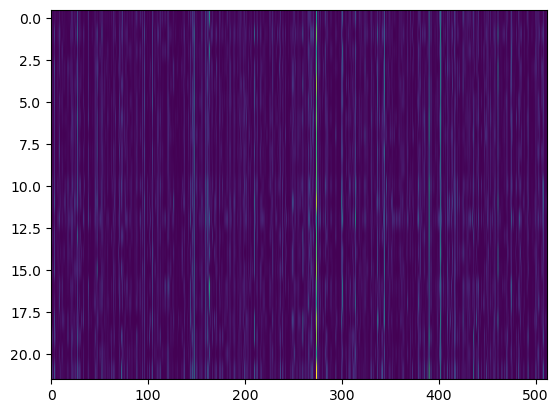

In [18]:
plt.imshow(features,aspect='auto')

In [9]:
import sklearn as skl
import matplotlib.pyplot as plt

In [15]:
hdb = skl.cluster.HDBSCAN(min_cluster_size=3)
hdb.fit(features)

,min_cluster_size,3
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,None
,metric,'euclidean'
,metric_params,None
,alpha,1.0
,algorithm,'auto'
,leaf_size,40
,n_jobs,None
,cluster_selection_method,'eom'


In [16]:
hdb.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1])

In [19]:
pca = skl.decomposition.PCA(n_components=2)
pca.fit(features)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [20]:
print(pca.explained_variance_ratio_)

[0.29933614 0.17255057]


In [22]:
X_embedded = skl.manifold.TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features)

In [26]:
X_embedded.shape

(22, 2)

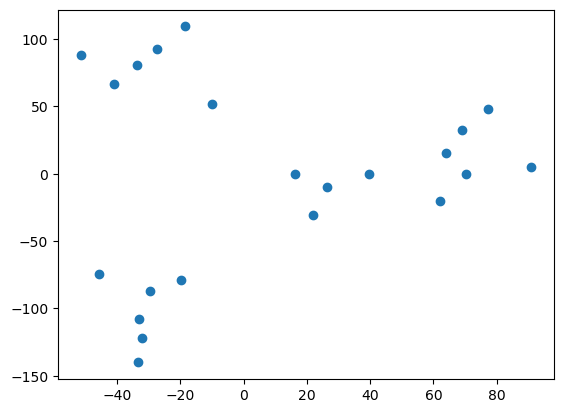

In [27]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],)

In [32]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [33]:
output_notebook()

Loading BokehJS ...

In [39]:
from bokeh.models import HoverTool

In [42]:
hover = HoverTool(tooltips=[('@x','@y')])
p = figure(width=400, height=400,tools=[hover])

# add a circle renderer with a size, color, and alpha
p.scatter(X_embedded[:,0],X_embedded[:,1], size=20, color="navy", alpha=0.5)


GlyphRenderer(id='p1213', ...)

In [43]:
show(p)